# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://tip.duke.edu/independent_learning/greek/lesson/digging_deeper_final.jpg)



In [5]:
!apt-get update
!pip3 install --upgrade pyglet

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Requirement already up-to-date: pyglet in /usr/local/lib/python3.6/dist-packages (1.5.0)


In [1]:
# In Google Colab, uncomment this:
!pip install gym
!apt-get install -y xvfb
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb
!apt-get install -y python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 107 not upgraded.
--2020-02-27 16:40:59--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640 [text/plain]
Saving to: ‘../xvfb’

../xvfb             100%[===================>]     640  --.-KB/s    in 0s      

2020-02-27 16:40:59 (33.8 MB/s) - ‘../xvfb’ saved [640/640]

Reading package lists... Done
Building dependency tree       
Reading state information..

In [1]:
# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


state vector dim = 4
n_actions = 2


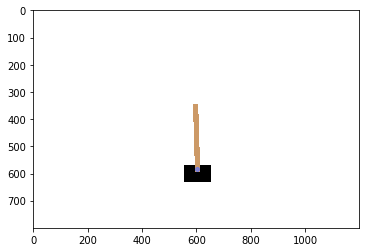

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [2]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [3]:
def generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s, ]).flatten()

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(range(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [4]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.03008853  0.03538164  0.03291151  0.0306754 ]
 [-0.0293809   0.23001654  0.03352501 -0.25144462]
 [-0.02478056  0.0344323   0.02849612  0.0516214 ]
 [-0.02409192  0.22913431  0.02952855 -0.23193631]
 [-0.01950923  0.42382215  0.02488982 -0.51516064]]
actions: [1, 0, 1, 1, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [5]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []

    for i in range(len(states_batch)):
        if rewards_batch[i] < reward_threshold:
            continue
        
        elite_states += states_batch[i]
        elite_actions += actions_batch[i]
    
    return np.array(elite_states), np.array(elite_actions)

# Training loop
Generate sessions, select N best and fit to those.

In [3]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 989.620, threshold=1000.000


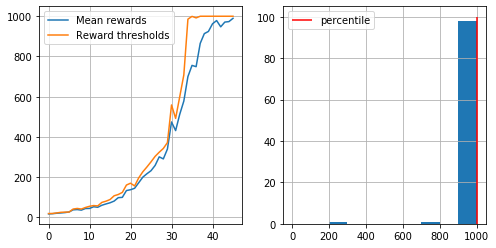

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [7]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(agent) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [13]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(agent, t_max=1000000) for _ in range(1)]
env.close()

/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
# show video
from IPython.display import Video
import os

video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

Video("./videos/"+video_names[-1])  # this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


### Codebase import

* generator of sessions

In [59]:
def generate_session_tabular(environment, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param environment: gym environment class
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = environment.reset()

    for t in range(t_max):
        a = np.random.choice(policy.shape[1], p=policy[s])

        new_s, r, done, info = environment.step(a)

        # Record state, action and add up reward to states,actions and total_reward accordingly.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

* selection of elite sessions

In [54]:
def select_elites_tabular(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    sessions_mask = rewards_batch >= reward_threshold
    elite_states = np.hstack(np.array(states_batch)[sessions_mask])
    elite_actions = np.hstack(np.array(actions_batch)[sessions_mask])
    return elite_states, elite_actions

* update policy

In [55]:
def update_tabular_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1

    empty_mask = (new_policy.sum(axis=1) == 0).reshape((-1, 1))
    new_policy += empty_mask * n_actions
    

    return new_policy / np.sum(new_policy, axis=1).reshape((-1, 1))

### Define everything to run expirements

In [67]:
def learn_tabular_policy(environment, policy, n_sessions=250, percentile=50, learning_rate=0.5):
    log = []

    for i in range(100):

        %time
        sessions = [generate_session_tabular(environment, policy) for i in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites_tabular(states_batch, actions_batch, rewards_batch, percentile)

        new_policy = update_tabular_policy(elite_states, elite_actions)

        policy = learning_rate*new_policy + (1-learning_rate)*policy

        # display results on chart
        show_progress(rewards_batch, log, percentile)

### Set environment

In [68]:
env_taxi = gym.make("Taxi-v3")
env_taxi.reset()

n_states = env.observation_space.n
n_actions = env.action_space.n
env_taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### Experiments with different `percentile` and/or `n_sessions`.

* standart case

mean reward = -101.856, threshold=4.500


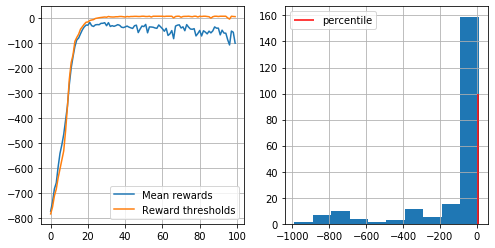

In [69]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions
learn_tabular_policy(env_taxi, policy)

* increase percentile

mean reward = -322.260, threshold=6.000


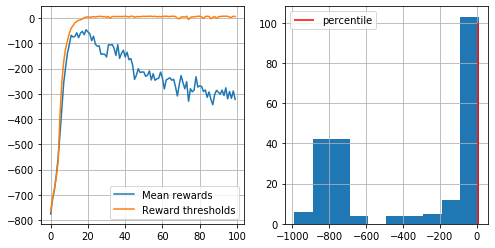

In [75]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions
learn_tabular_policy(env_taxi, policy, percentile=65)

mean reward = -475.836, threshold=0.400


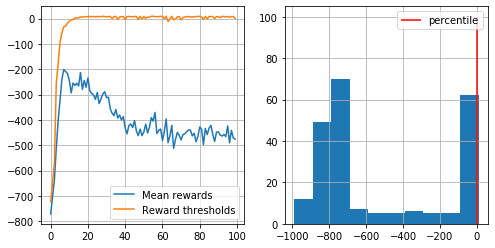

In [76]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions
learn_tabular_policy(env_taxi, policy, percentile=80)

**Conclusion:** We faster converge 0, but mean revard begins to degrade. I think that this is due to lack of sessions, and it consist of only lucky cases

* increase percentile

mean reward = -6.224, threshold=4.150


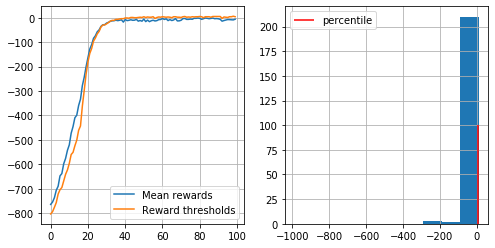

In [79]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions
learn_tabular_policy(env_taxi, policy, percentile=35)

mean reward = 0.192, threshold=-2.000


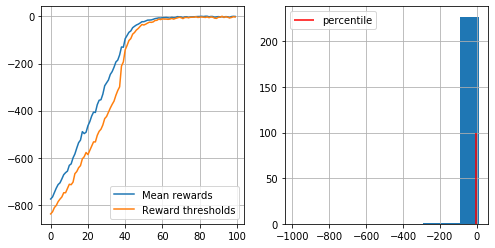

In [80]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions
learn_tabular_policy(env_taxi, policy, percentile=20)

**Conclusion:** with lower percentile policy converge slowly, but mean value is more stable. So this parameter works like *regularization*
 

* increase number of sessions

mean reward = 2.438, threshold=2.000


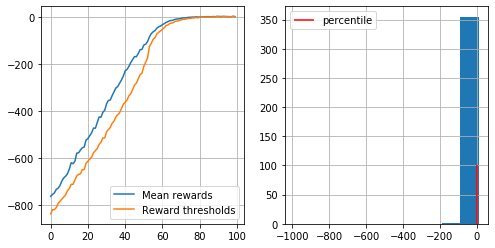

In [83]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions
learn_tabular_policy(env_taxi, policy, n_sessions=400, percentile=20)

**Conclusion:** For good learning we need more sessions and lower percentile

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pt) Devise a way to speed up training against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
__Please list what you did in anytask submission form__. __It's necessary to measure your improvement experimentally__.  __You score depends on this improvement. If the algorithm converges 2x faster, you obtain 3 pts. If the algorithm converges 4x faster, you obtain 6pts__.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

## Task 2.1

**MAIN CHANGES:**

* cut rewards via ">" and not ">="
* use (30, 10) MLP

### Codebase import 

* generate session for agent

In [4]:
def generate_session_agent(environment, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = environment.reset()

    for t in range(t_max):
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s, ]).flatten()

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        a = np.random.choice(range(n_actions), p=probs)

        new_s, r, done, info = environment.step(a)

        # record sessions
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

* select elite sessions

In [5]:
def select_elites_agent(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    flag = False
    for i in range(len(states_batch)):
        if rewards_batch[i] <= reward_threshold:
            continue

        elite_states += [e for e in states_batch[i]]        
        elite_actions += [e for e in actions_batch[i]]
        flag = True

    if not len(elite_states):
        print(reward_threshold)
        assert 0
        
    if not len(elite_actions):
        assert 0
        
    return np.vstack(elite_states), np.vstack(elite_actions)

### Preparation to run expirements

In [14]:
def learn_mlp_policy(environment, agent, n_sessions=100, percentile=50, epoch=100, target_reward=50, t_max=1000):
    log = []

    for i in range(epoch):
        # generate new sessions
        sessions = [generate_session_agent(environment, agent, t_max=t_max) for i in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

        elite_states, elite_actions = select_elites_agent(states_batch, actions_batch, rewards_batch, percentile)
        agent.partial_fit(elite_states, elite_actions)

        show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

        if np.mean(rewards_batch) > target_reward * 1.1:
            print("You Win! learning")
            break

### Set environment

In [15]:
env_lunar = gym.make("LunarLander-v2").env

env_lunar.reset()
n_actions = env_lunar.action_space.n
state_dim = env_lunar.observation_space.shape[0]
print(n_actions, state_dim)

4 8


/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Define agent model

In [16]:
def get_MLP_agent(environment):
    agent = MLPClassifier(
        hidden_layer_sizes=(30, 10),
        activation='tanh',
    )

    # initialize agent to the dimension of state space and number of actions
    agent.partial_fit([environment.reset()] * n_actions, range(n_actions), range(n_actions))
    return agent

### Try to win game

* with standart params

mean reward = 56.595, threshold=76.476


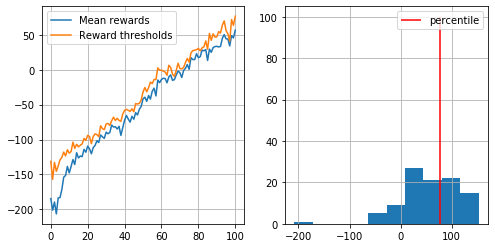

You Win! learning
CPU times: user 33min 13s, sys: 8.23 s, total: 33min 21s
Wall time: 33min


In [17]:
%%time
agent = get_MLP_agent(env_lunar)
learn_mlp_policy(env_lunar, agent, epoch=120, n_sessions=100, percentile=60, t_max=1000)

## Visualisation

In [21]:
# record sessions
env = gym.wrappers.Monitor(gym.make("LunarLander-v2").env,
                           directory="videos", force=True)
sessions = [generate_session_agent(env, agent, t_max=1000) for _ in range(3)]
env.close()

/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Task 2.2

* generate session by agent (prepare for parallel)

In [22]:
a, b, c = [], [], []
a, b, c += [1], [2], [3]

SyntaxError: illegal expression for augmented assignment (<ipython-input-22-84a14164cf82>, line 2)

In [37]:
from copy import deepcopy

def generate_session_agent(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    environment = gym.make("LunarLander-v2").env
    agent = deepcopy(agent)
    states, actions = [], []
    total_reward = 0

    s = environment.reset()

    for t in range(t_max):
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s, ]).flatten()

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        a = np.random.choice(range(n_actions), p=probs)

        new_s, r, done, info = environment.step(a)

        # record sessions
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

### Preparation to run expirements

In [50]:
from joblib import Parallel, delayed

def learn_mlp_policy_fast(agent, n_sessions=100, percentile=50, epoch=100, target_reward=50, t_max=1000, n_jobs=2, hold_iters=3):
    log = []
    sessions_stack = []
    for i in range(epoch):
        # generate new sessions
        new_sessions = Parallel(n_jobs=n_jobs)(delayed(generate_session_agent)(agent, t_max=t_max) for i in range(n_sessions))
        sessions_stack += new_sessions
        if len(sessions_stack) > hold_iters * n_sessions:
            sessions_stack = sessions_stack[n_sessions:]

        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions_stack))

        elite_states, elite_actions = select_elites_agent(states_batch, actions_batch, rewards_batch, percentile)
        agent.partial_fit(elite_states, elite_actions)

        show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

        if np.mean(rewards_batch) > target_reward * 1.1:
            print("You Win! learning")
            break

### Set environment

In [51]:
env_lunar = gym.make("LunarLander-v2").env

env_lunar.reset()
n_actions = env_lunar.action_space.n
state_dim = env_lunar.observation_space.shape[0]
print(n_actions, state_dim)

4 8


/Users/alex-kozinov/dl/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Define agent

In [52]:
def get_MLP_agent(environment):
    agent = MLPClassifier(
        hidden_layer_sizes=(30, 10),
        activation='tanh',
    )

    # initialize agent to the dimension of state space and number of actions
    agent.partial_fit([environment.reset()] * n_actions, range(n_actions), range(n_actions))
    return agent

### Try to speed up game

mean reward = 55.216, threshold=66.792


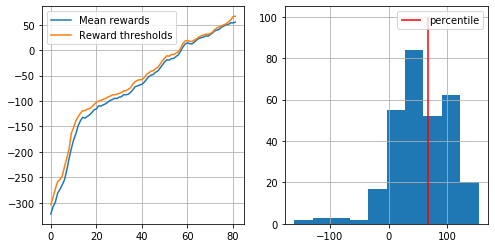

You Win! learning
CPU times: user 2min 12s, sys: 2.81 s, total: 2min 15s
Wall time: 9min 42s


In [53]:
%%time
agent = get_MLP_agent(env_lunar)
learn_mlp_policy_fast(agent, epoch=120, n_sessions=100, percentile=60, t_max=1000)

**WIIIN** We hav an invrease from 34 minutes to 9 minutes. Almost in 4 times!

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).